In [1]:
from pathlib import Path

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import xarray as xr
from cartopy.mpl.gridliner import LatitudeFormatter, LongitudeFormatter
from nzmeltwater.util import cleanocn
from xesmf import Regridder

mpl.rcParams["figure.figsize"] = 6, 4
mpl.rcParams["font.size"] = 12

### Load ssp585 and ssp585-imsip6-water temperature and salinity at 100m depth data

In [2]:
ddict = {}
droot = Path("../data/processed/HadGEM3-GC31-LL")

variables = ["so", "thetao"]

In [3]:
ddict = {}

for var in variables:
    cdir = droot.joinpath("ssp585", "Omon", var + "100")
    sdir = droot.joinpath("ssp585-ismip6-water", "Omon", var + "100")
    ncc = cdir.joinpath(f"{var}_Omon_HadGEM3-GC31-LL_ssp585_ens_gn_205001-210012.nc")
    nce = sdir.joinpath(
        f"{var}_Omon_HadGEM3-GC31-LL_ssp585-ismip6-water_ens_gn_201501-210012.nc"
    )

    dsc = xr.open_dataset(ncc)
    dse = xr.open_dataset(nce)
    ddict[var] = {
        "ctrl": dsc[var].isel(time=slice(-240, None)),
        "expt": dse[var].isel(time=slice(-240, None)),
    }

In [4]:
def rectilinear_regrid(da):
    # Regrid da to rectilinear grid so that contour/contourf works
    rlat = np.arange(-90, 91)
    rlon = np.arange(-180, 181)

    dsout = xr.DataArray(
        np.zeros((rlat.size, rlon.size)),
        dims=["j", "i"],
        coords={"lat": ("j", rlat), "lon": ("i", rlon)},
    )

    regridder = Regridder(da, dsout, method="bilinear", periodic=True)
    da_r = regridder(da)

    return da_r

### Regrid data to regular lat/lon grid

In [5]:
regriddictc = {}
regriddicts = {}

for var in variables:
    regriddictc[var] = rectilinear_regrid(ddict[var]["ctrl"].mean(("ensmem", "time")))
    regriddicts[var] = rectilinear_regrid(ddict[var]["expt"].mean(("ensmem", "time")))

In [6]:
def plotcont(axs, data1, data2, cvalue, title, labels, tflag=True):
    # Plotting function
    if title == "STF$_{TEMP}$":
        delta = 1
    else:
        delta = 0.2
        data1 = data1.where(data1.lat > -56)
        data2 = data2.where(data2.lat > -56)
    axs.coastlines(zorder=101)
    axs.set_extent([145, 200, -60, -20], crs=ccrs.PlateCarree())
    axs.add_feature(cfeature.LAND, color="tab:gray", zorder=100)
    gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, zorder=102)
    gl.xlocator = mticker.FixedLocator([160, 180])
    gl.ylocator = mticker.FixedLocator([-45, -30, -15])
    gl.top_labels = False
    gl.bottom_labels = True
    gl.left_labels = True
    gl.xformatter = LongitudeFormatter(dateline_direction_label=True)
    gl.xlabel_style = {"size": 8, "color": "k"}
    gl.ylabel_style = {"size": 8, "color": "k", "rotation": 90}
    cs1 = data1.plot.contourf(
        "lon",
        "lat",
        levels=[cvalue - delta, cvalue + delta],
        colors=["w", "b", "w"],
        alpha=0.3,
        ax=axs,
        transform=ccrs.PlateCarree(),
        add_colorbar=False,
    )

    cs2 = data2.plot.contourf(
        "lon",
        "lat",
        levels=[cvalue - delta, cvalue + delta],
        colors=["w", "r", "w"],
        alpha=0.3,
        ax=axs,
        transform=ccrs.PlateCarree(),
        add_colorbar=False,
    )

    cs1a = data1.plot.contour(
        "lon",
        "lat",
        levels=[cvalue],
        colors=["b"],
        ax=axs,
        transform=ccrs.PlateCarree(),
        add_colorbar=False,
        zorder=100,
    )
    cs2a = data2.plot.contour(
        "lon",
        "lat",
        levels=[cvalue],
        colors=["r"],
        ax=axs,
        transform=ccrs.PlateCarree(),
        add_colorbar=False,
        zorder=100,
    )

    artists, ap = cs1a.legend_elements()
    artists2, ap = cs2a.legend_elements()

    if title == "STF$_{SALT}$":
        axs.legend(
            handles=[artists[0], artists2[0]],
            labels=labels,
            fontsize=10,
            loc="center left",
            bbox_to_anchor=(1.0, 0.5),
        )

    if tflag:
        axs.set_title(title)
    else:
        axs.set_title("")

    return cs1, cs2

### Load first 20 and last 20 years of ssp585 to compute anomaly with warming

In [9]:
cdict = {}

for var in variables:
    cdir = droot.joinpath("ssp585", "Omon", var + "100")
    ncc = cdir.joinpath(f"{var}_Omon_HadGEM3-GC31-LL_ssp585_ens_gn_201501-210012.nc")

    dsc = xr.open_dataset(ncc)
    cdict[var] = {
        "ctrl": dsc[var].isel(time=slice(None, 240)),
        "expt": dsc[var].isel(time=slice(-240, None)),
    }

In [10]:
rdictc = {}
rdicts = {}

for var in variables:
    rdictc[var] = rectilinear_regrid(
        cdict[var]["ctrl"].mean(("ensmem", "time"))
    )
    rdicts[var] = rectilinear_regrid(
        cdict[var]["expt"].mean(("ensmem", "time"))
    )

### Make combined plot for paper

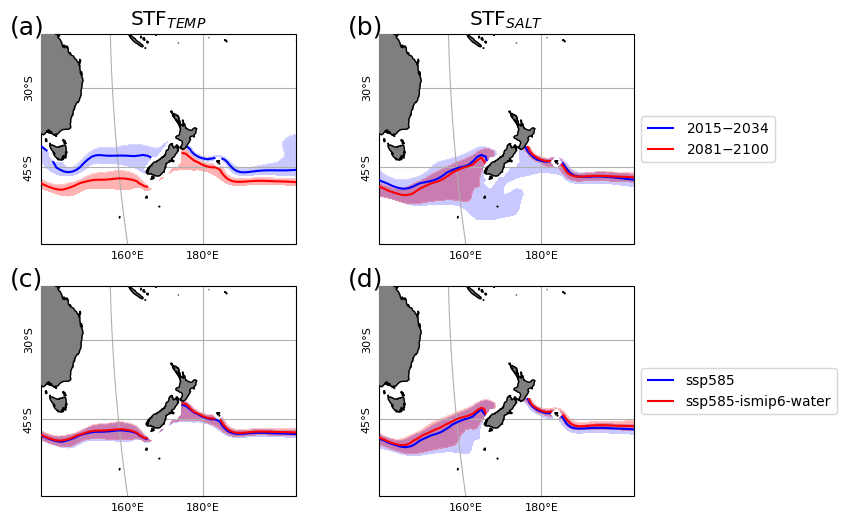

In [12]:
fig, (ax1, ax2) = plt.subplots(
    2,
    2,
    figsize=(8, 6),
    subplot_kw={"projection": ccrs.Robinson(central_longitude=180)},
)

cs1, cs2 = plotcont(
    ax1[0],
    rdictc["thetao"],
    rdicts["thetao"],
    13,
    "STF$_{TEMP}$",
    ["2015$-$2034", "2081$-$2100"],
)
cs1, cs2 = plotcont(
    ax1[1],
    rdictc["so"],
    rdicts["so"],
    34,
    "STF$_{SALT}$",
    ["2015$-$2034", "2081$-$2100"],
)

cs1, cs2 = plotcont(
    ax2[0],
    regriddictc["thetao"],
    regriddicts["thetao"],
    13,
    "STF$_{TEMP}$",
    ["ssp585", "ssp585-ismip6-water"],
    tflag=False,
)
cs1, cs2 = plotcont(
    ax2[1],
    regriddictc["so"],
    regriddicts["so"],
    34,
    "STF$_{SALT}$",
    ["ssp585", "ssp585-ismip6-water"],
    tflag=False,
)

ax1[0].annotate("(a)", xy=(-0.12, 1.0), xycoords="axes fraction", fontsize=18)
ax1[1].annotate("(b)", xy=(-0.12, 1.0), xycoords="axes fraction", fontsize=18)
ax2[0].annotate("(c)", xy=(-0.12, 1.0), xycoords="axes fraction", fontsize=18)
ax2[1].annotate("(d)", xy=(-0.12, 1.0), xycoords="axes fraction", fontsize=18)

fig.savefig(
    "../figures/tier2_STF_comparison.png", bbox_inches="tight", dpi=300
)